In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# All skl imports go here
from sklearn import tree   # Decision Trees
from sklearn import svm    # svm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics
import sklearn as skl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

In [3]:
# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [4]:
# Perform pre-processing PCA on the training set
def perform_pca(dataset, target_variance):
    pca = PCA(n_components= target_variance)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced

In [5]:
TARGET_EXPLAINED_VARIANCE = 0.999999

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_redced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

768 components for training


In [6]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()


# K-Folds Cross Validation

In [7]:

def k_folds_x_val(model, X, y, k =  5): 
    results = cross_validate(model, X, y, cv=k, scoring=["accuracy"])
    mean_accuracy = results['test_accuracy'].mean()
    print(f"Mean Accuracy: {mean_accuracy}")
    return mean_accuracy, 

def get_cmat(model, X, y):
    y_pred = model.predict(X)
    return confusion_matrix(y, y_pred, normalize="pred")

def get_metrics(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred), f1_score(y, y_pred, average="weighted")

# Grid Search Hyperparameter Optimization

In [8]:
def gridSearchHPO(model, search_space):
    grid_search = GridSearchCV(estimator=model,
                                param_grid=search_space,
                                scoring='accuracy',
                                cv=5,
                                verbose=3,
                                error_score='raise',
                                n_jobs=-1,  # -1 means max amount
                                )
    return grid_search

# Decision Trees

In [8]:
decision_tree_model = tree.DecisionTreeClassifier(
    criterion ='entropy', 
    splitter = 'best',
    max_depth = 256, 
    max_features = 'sqrt',
    max_leaf_nodes = 80,
)

In [34]:
# ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 
# 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter']
dt_search_space = {
    # 'ccp_alpha':[0.1, 0.2, 0.4, 0.5],
    'max_leaf_nodes':[71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 
    # 'min_impurity_decrease':[1.0, 0.5, 1.5, 2.0], # float
    # 'min_weight_fraction_leaf':[0.1, 0.2, 0.4, 0.5],
    'max_depth':[255, 256, 257, 258, 259, 260], 
    # 'max_features':["log2", "sqrt"], 
    # 'min_samples_leaf':[0.1, 0.2, 0.4, 0.5], 
    # 'min_samples_split':[0.1, 0.2, 0.4, 0.5]
    }

model_dt = decision_tree_model.fit(X_train, Y_train)

gridsearch_dt = gridSearchHPO(model=model_dt, search_space=dt_search_space)

c:\Users\techt\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
gridsearch_dt.fit(X_train, Y_train)

In [35]:
print("Best Score: {}".format(gridsearch_dt.best_score_))
print("Best params: {}".format(gridsearch_dt.best_params_))

{'max_depth': 8,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 16}

# SVMs

In [11]:
svm_classifier = svm.SVC(max_iter=-1)

#Train the model using the training sets
svm_classifier.fit(X_train, Y_train)

#Predict the response for test dataset
# k_folds_x_val(svm_classifier)

Performed 10-fold cross validation
Average accuracy 0.5808888888888889
Average Kappa 0.4227651194469132


In [ ]:
svm_search_space={
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['poly'], # poly - 'rbf', 'linear', 'sigmoid' 
    'degree': [3],  # 3
    'gamma': ['scale'], #'auto',  1, 0.1, 0.01, 0.001, 0.0001, 
    'coef0': [0.0, 0.1, 0.2, 0.5, 0.8, 1.0], 
    'shrinking': [True], 
    'probability': [False], 
    'tol': [0.1],  
    'class_weight': [None], 
    'decision_function_shape': ['ovr'], # 'ovo'
}

gridsearch_svm = gridSearchHPO(svm_classifier, svm_search_space)

In [ ]:
gridsearch_svm.fit(X_train, Y_train)

In [ ]:
print("Best Score: {}".format(gridsearch_svm.best_score_))
print("Best params: {}".format(gridsearch_svm.best_params_))

# Pytorch Setup

In [19]:
# Pytorch specific constants
from torch.utils.data import TensorDataset, DataLoader
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate
import torch

BATCH_SIZE = 16
LEARNING_RATE = 1e-3

# MLP

In [67]:
X_train_used = X_train_unreduced
X_test_used = X_test_unreduced
X_val_used = X_val_unreduced
X_train_val_used = X_train_val_unreduced
X_val_test_used = X_val_test_unreduced

In [68]:
mlp = MLPClassifier([], 'relu', solver="adam")
mlp.fit(X_train_used, Y_train)

c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=[])

In [69]:
k_folds_x_val(mlp, X_train_val_used, Y_train_val)

c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Accuracy: 0.5924444444444443


c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.5924444444444443,)

(0.644, 0.6298770559202335)


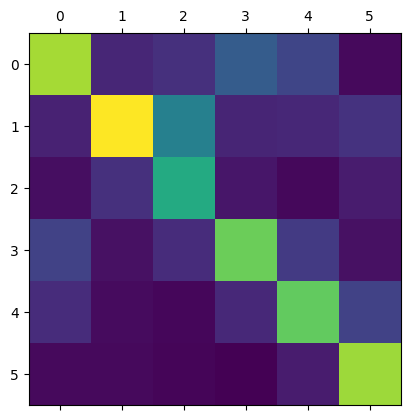

In [70]:
cmat = get_cmat(mlp, X_val_test_used, Y_val_test)
print(get_metrics(mlp, X_val_test_used, Y_val_test))
plt.matshow(cmat)
plt.show()

In [71]:
from utils.neuralnet import NeuralNetwork
from utils.trainer import training_loop, evaluate

In [72]:
# For pytorch specifically we should load data to the provided dataloader and dataset classes. 
# This handles the batching for us.

pt_train_set = TensorDataset(torch.Tensor(X_train_used), torch.Tensor(Y_train.to_numpy()).long())
pt_val_set = TensorDataset(torch.Tensor(X_val_used), torch.Tensor(Y_val.to_numpy()).long())
pt_test_set = TensorDataset(torch.Tensor(X_test_used), torch.Tensor(Y_test.to_numpy()).long())
pt_val_test_set = TensorDataset(torch.Tensor(X_val_test_used), torch.Tensor(Y_val_test.to_numpy()).long())

pt_train_loader = DataLoader(
                    dataset=pt_train_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_val_loader = DataLoader(
                    dataset=pt_val_set, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                )
pt_test_loader = DataLoader(
                    dataset=pt_test_set, 
                    batch_size=1, 
                    shuffle=True,
                )

pt_val_test_loader = DataLoader(
                    dataset=pt_val_test_set, 
                    batch_size=1, 
                    shuffle=True,
                )

In [73]:
# Initialize neural network
mlp = NeuralNetwork(X_train_reduced.shape[1], [], NUM_CLASSES)

training_loop(mlp, pt_train_loader, pt_val_loader, 200, LEARNING_RATE)

Epoch 1
train_loss = 1.3991, val_loss = 1.2492
Epoch 2
train_loss = 0.9950, val_loss = 1.1155
Epoch 3
train_loss = 1.0995, val_loss = 1.0540
Epoch 4
train_loss = 0.7503, val_loss = 1.0163
Epoch 5
train_loss = 1.0224, val_loss = 0.9940
Epoch 6
train_loss = 0.9480, val_loss = 0.9824
Epoch 7
train_loss = 0.8059, val_loss = 0.9722
Epoch 8
train_loss = 0.5716, val_loss = 0.9646
Epoch 9
train_loss = 0.8199, val_loss = 0.9612
Epoch 10
train_loss = 0.5734, val_loss = 0.9556
Epoch 11
train_loss = 0.7246, val_loss = 0.9558
Epoch 12
train_loss = 1.0077, val_loss = 0.9514
Epoch 13
train_loss = 0.8350, val_loss = 0.9503
Epoch 14
train_loss = 1.0596, val_loss = 0.9500
Epoch 15
train_loss = 0.9478, val_loss = 0.9488
Epoch 16
train_loss = 1.1377, val_loss = 0.9470
Epoch 17
train_loss = 0.7169, val_loss = 0.9456
Epoch 18
train_loss = 0.7632, val_loss = 0.9436
Epoch 19
train_loss = 0.6606, val_loss = 0.9444
Epoch 20
train_loss = 0.8541, val_loss = 0.9424
Epoch 21
train_loss = 0.6883, val_loss = 0.9435
E

loss = 0.9508
accuracy = 0.6408
f1 = 0.6231
[[0.62032885 0.08650938 0.08421053 0.21024259 0.16266667 0.04109589]
 [0.07473842 0.71264368 0.32105263 0.07008086 0.07733333 0.06849315]
 [0.03363229 0.10344828 0.47368421 0.04851752 0.024      0.05479452]
 [0.15695067 0.03932244 0.09473684 0.5606469  0.12266667 0.04109589]
 [0.09118087 0.03206292 0.01578947 0.09973046 0.56       0.15068493]
 [0.02316891 0.02601331 0.01052632 0.01078167 0.05333333 0.64383562]]


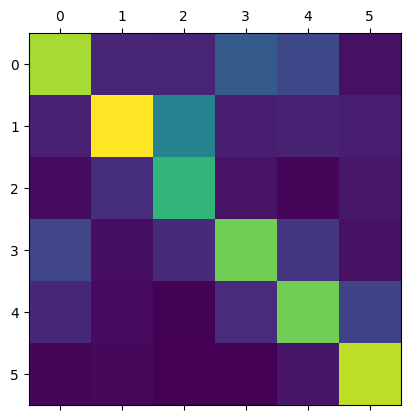

In [74]:
_, _, _, cmat = evaluate(model=mlp, val_dl=pt_val_test_loader)
print(cmat)
plt.matshow(cmat)
plt.show()

# K Means

In [25]:
k_list = [2, 3, 4, 5, 6, 8, 10, 12, 16, 32, 48, 64, 128, 256, 512]
dbi_score_list = []
for k in k_list:
    # Create a KMeans model with the specified number of clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')

    # Fit the K-Means model to your data
    kmeans.fit(X_train)

    # Get the cluster assignments for each data point
    labels = kmeans.labels_

    # Calculate the Davies-Bouldin Index (DBI) to evaluate the clustering
    dbi_score = davies_bouldin_score(X_train, labels)
    dbi_score_list.append((k, dbi_score))

Highest DBI Score: K=2, DBI=4.525119278895166


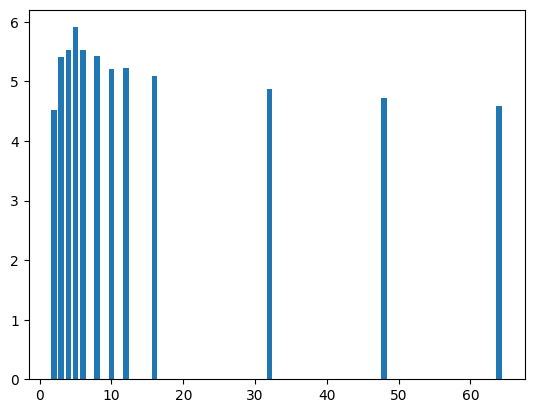

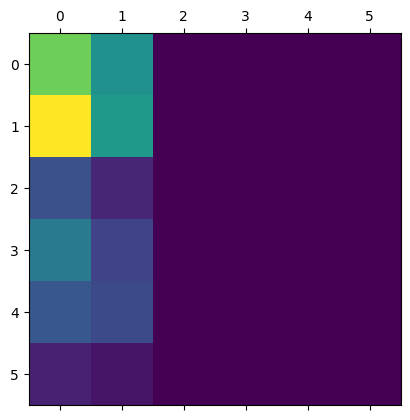

In [24]:
best_dbi = min(dbi_score_list, key = lambda i : i[1])
print(f"Highest DBI Score: K={best_dbi[0]}, DBI={best_dbi[1]}")

kmeans_best = KMeans(n_clusters=best_dbi[0], random_state=42, n_init='auto')

kmeans_best.fit(X_test)
preds = kmeans_best.predict(X_test)
cmat = confusion_matrix(Y_test, preds)

plt.bar([x for (x,y) in dbi_score_list], [y for (x,y) in dbi_score_list])
plt.matshow(cmat)
plt.show()